# DU-GD法 (最小二乗問題)

周期性条件あり

Copyright (c) 2022 Tadashi Wadayama  
Released under the MIT license  
https://opensource.org/licenses/mit-license.php

In [1]:
using LinearAlgebra
using Plots
gr()
using Random
Random.seed!(1)
using Flux

### 準備 (グローバル定数の設定)

In [2]:
n = 50
m = 100
num_itr = 50
K = 100
adam_lr = 1e-4
max_inner = 40 

A = randn(m,n)
Pinv = (A'*A)^(-1)*A'
eig = eigvals(A'*A)
λmin = minimum(eig)
λmax = maximum(eig)
ηopt = 2/(λmin + λmax)

0.006420414030917664

### ミニバッチ生成関数

In [3]:
function mini_batch(K)
    y = randn(m,K)
    x_opt = Pinv*y
    return y, x_opt
end

mini_batch (generic function with 1 method)

### 固定ステップサイズのGD法のMSE

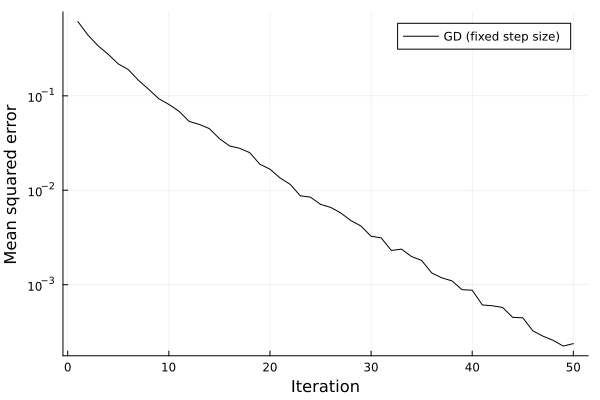

In [4]:
function GD(max_itr, y)
    x = zeros(n, K)
    for i in 1:max_itr
        x = x - ηopt*A'*(A*x - y)
    end
    return x
end

function comp_mse(max_itr)
    y, x_opt = mini_batch(K)
    x̂ = GD(max_itr, y)
    return norm(x_opt - x̂)^2/K
end
        
GD_mse = [comp_mse(i) for i in 1:num_itr]
plot(1:num_itr, GD_mse, lw=1, yscale=:log10, label="GD (fixed step size)", color=:black,  xlabel="Iteration", ylabel="Mean squared error")

### DU-GD反復の定義 

In [5]:
function DU_GD(max_itr, y, η, T)
    x = zeros(n, K)
    for i in 0:max_itr-1
        k = (i % T)+1
        x = x - η[k]*A'*(A*x - y)
    end
    return x
end

DU_GD (generic function with 1 method)

### 損失関数の定義

In [6]:
function loss(x_opt, x̂)
    return norm(x_opt - x̂)^2/K
end     

loss (generic function with 1 method)

### 訓練関数の定義

In [7]:
function train(opt, η, T)
    ps = Flux.params(η) 
    for itr in 1:num_itr
        for i in 1:max_inner
            y, x_opt = mini_batch(K)
            gs = Flux.gradient(ps) do
                x_est = DU_GD(itr, y, η, T)
                loss(x_opt, x_est)
            end
            Flux.Optimise.update!(opt, ps, gs)
        end
        y, x_opt = mini_batch(K)
        x_est = DU_GD(itr, y, η, T)
        println(itr, " ", loss(x_opt, x_est))
    end
end

train (generic function with 1 method)

### DU-GDのMSE評価用関数

In [8]:
function comp_mse_DUGD(max_itr, η, T)
    y, x_opt = mini_batch(K)
    x̂ = DU_GD(max_itr, y, η, T)
    return loss(x_opt, x̂)
end

comp_mse_DUGD (generic function with 1 method)

### 学習過程 $(T=2)$

1 0.7366693435028967
2 0.4725527957363341
3 0.3098347461808697
4 0.23944326868766286
5 0.18068064437826373
6 0.14600051595037394
7 0.09677815086413229
8 0.07248342545711059
9 0.055110618144316594
10 0.03886612811545822
11 0.022470757591095444
12 0.021913842311922636
13 0.013157272363156301
14 0.012366237144845527
15 0.007000208475948094
16 0.006791466318651251
17 0.0038614003184503846
18 0.00309338857653938
19 0.002279437197682043
20 0.0018231073829069356
21 0.001369830920202377
22 0.0012064640552255544
23 0.0007385290299242875
24 0.0007533442696468168
25 0.0004325389667920385
26 0.0004089441147968352
27 0.00029043861959055243
28 0.00028868344517944287
29 0.00020526057487957498
30 0.0001639105892921245
31 0.000130484529336539
32 0.00010457807529545561
33 7.339441428818244e-5
34 5.170759069491756e-5
35 4.4692804693041874e-5
36 3.746094938815445e-5
37 2.620417027854832e-5
38 2.5056331160928017e-5
39 1.5236604622719658e-5
40 1.5145113715220454e-5
41 8.740413807913387e-6
42 1.1165937921805

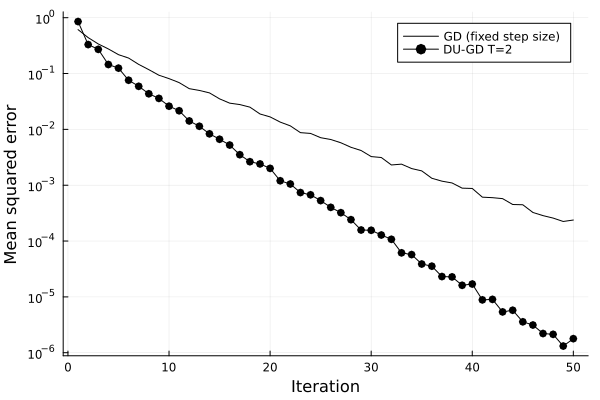

In [9]:
T = 2
η_train = zeros(T) 
opt = Flux.ADAM(adam_lr) 
@time train(opt, η_train, T)
DUGD_mse =[comp_mse_DUGD(i, η_train, T) for i in 1:num_itr]
opt_param1 = [η_train[(i%T)+1] for i in 0:num_itr-1]
plot!(1:num_itr, DUGD_mse, lw=1, label="DU-GD T="*string(T), color=:black, marker=:o)

### 学習過程 $(T=8)$

1 0.7608035193446864
2 0.47765027032244217
3 0.2924170961602537
4 0.22312905821923995
5 0.15005488468558248
6 0.09384734010280532
7 0.06864116372961403
8 0.04965033168807323
9 0.03485434903491609
10 0.02268021276870258
11 0.025475521800222577
12 0.01996371989714373
13 0.01176026744483271
14 0.009295168348417515
15 0.007967838220535315
16 0.006643576194397939
17 0.006051097361651476
18 0.003753333410787157
19 0.002224813397997512
20 0.001762785445353509
21 0.0011244455490052594
22 0.0011476159643332919
23 0.0007704465087270456
24 0.0006980551684226649
25 0.0006134370603911633
26 0.0004224309439358391
27 0.00025907942040013176
28 0.0002594625932308149
29 0.00015296188388860002
30 0.00011270192760733384
31 0.00013299326915497384
32 0.00011170033591115317
33 8.912757607118417e-5
34 5.5389863755980946e-5
35 4.0529008079431646e-5
36 3.886774693895539e-5
37 2.2886668683583396e-5
38 2.0508138286844535e-5
39 1.4368032805989293e-5
40 1.816684082158532e-5
41 1.725536332091829e-5
42 1.140770262603

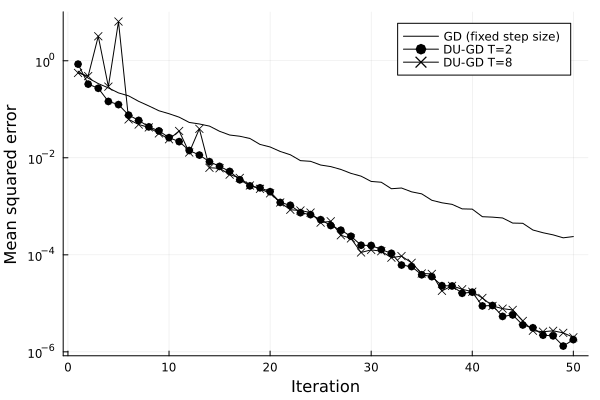

In [10]:
T = 8
η_train = zeros(T) 
opt = Flux.ADAM(adam_lr) 
train(opt, η_train, T)
DUGD_mse =[comp_mse_DUGD(i, η_train, T) for i in 1:num_itr]
opt_param2 = [η_train[(i%T)+1] for i in 0:num_itr-1]
plot!(1:num_itr, DUGD_mse, lw=1, label="DU-GD T="*string(T), color=:black, marker=:x)

In [11]:
savefig("DU-GD-LMS.pdf")

"/Users/wadayama/Dropbox/DU-Book_test/Chapter_3/DU-GD-LMS.pdf"

### 学習後のパラメータのプロット

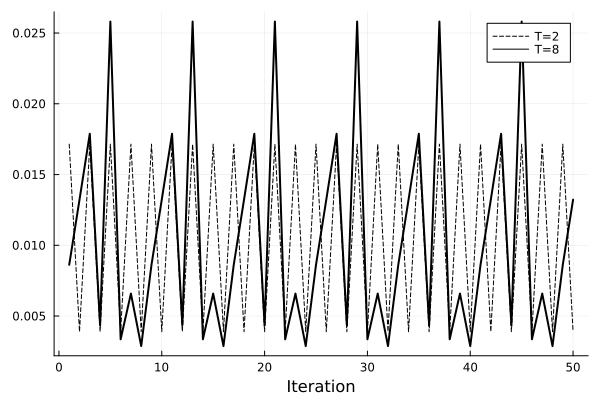

In [12]:
plot(1:num_itr, opt_param1, lw=1, label="T=2", color=:black, ls=:dash, xlabel="Iteration")
plot!(1:num_itr, opt_param2, lw=2, label="T=8", color=:black)

In [13]:
savefig("DU-GD-params.pdf")

"/Users/wadayama/Dropbox/DU-Book_test/Chapter_3/DU-GD-params.pdf"